In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cooler
import cooltools.lib.plotting
from cooltools import insulation
import cooltools

In [2]:
resolution = 10000
clr = cooler.Cooler(f"/exports/igmm/eddie/wendy-lab/ilia/interactions_screen_quaich/inputs/coolers/Hsieh_mESCs_microC.mm10.mapq_30.1000.mcool::/resolutions/{resolution}")

In [3]:
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
insulation_table = insulation(clr, windows, verbose=True)

INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root:Processing region chr8
INFO:root:Processing region chr9
INFO:root:Processing region chr10
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chrX
INFO:root:Processing region chrY
INFO:root:Processing region chrM


In [4]:
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

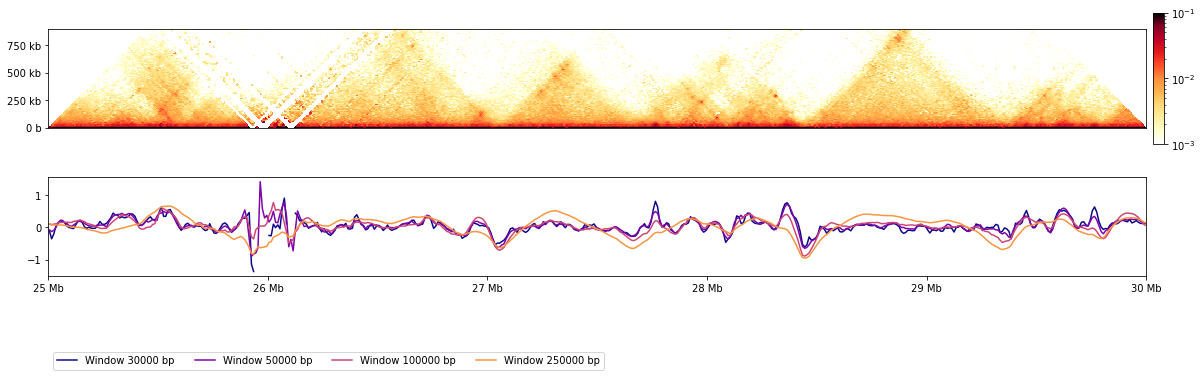

In [5]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
plt.rcParams['font.size'] = 12

start = 25_000_000
end = 30_000_000
region = ('chr5', start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 30*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), 
            insul_region['log2_insulation_score_'+str(windows[0])],
            label=f'Window {windows[0]} bp')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

for res in windows[1:]:
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region[f'log2_insulation_score_{res}'], label=f'Window {res} bp')
ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

(25000000.0, 30000000.0)

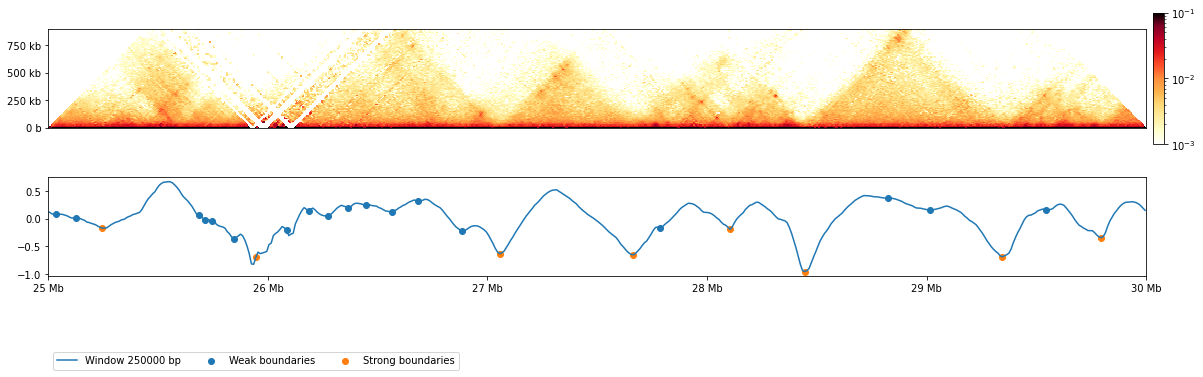

In [6]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 30*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

window=windows[3]

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{window}'], label=f'Window {window} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{window}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{window}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{window}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1), 
            weak_boundaries[f'log2_insulation_score_{window}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1), 
            strong_boundaries[f'log2_insulation_score_{window}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

In [7]:
TAD_250kb = insulation_table.loc[~insulation_table["is_bad_bin"] & 
                          insulation_table["is_boundary_250000"], ["chrom", "start"]]

TAD_250kb["end"] = TAD_250kb['start'].shift(-1)
TAD_250kb = TAD_250kb.dropna()
TAD_250kb["end"] = TAD_250kb["end"].astype(int)

TAD_250kb = TAD_250kb.reset_index(drop=True).reset_index(names="TAD")
TAD_250kb = TAD_250kb[["chrom", "start", "end", "TAD"]]

TAD_250kb["chrom2"] = TAD_250kb["chrom"].shift(-1)

TAD_250kb = TAD_250kb.loc[TAD_250kb["chrom"] == TAD_250kb["chrom2"], ["chrom", "start", "end", "TAD"]]

In [8]:
TAD_250kb.to_csv("Hsieh_microC_TADs_250kb.bed", 
           sep="\t", index=False)